In [1]:
from __future__ import absolute_import
from __future__ import print_function
from tqdm import tqdm
#image are imported with a resizing and a black and white conversion
from PIL import Image
from pandas import read_csv
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import pickle
import numpy as np
from imagehash import phash
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import History
from keras.optimizers import Adam

DIR = "/work/t-jachen/.kaggle/competitions/whale-categorization-playground"
tagged = dict([(p,w) for _,p,w in read_csv(DIR + '/train.csv').to_records()])
submit = [p for _,p,_ in read_csv(DIR + '/sample_submission.csv').to_records()]
join   = list(tagged.keys()) + submit
len(tagged),len(submit),len(join),list(tagged.items())[:5],submit[:5]

from subprocess import check_output
print(check_output(["ls", DIR]).decode("utf8"))

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K

from tqdm import tqdm

import sys
old_stderr = sys.stderr
sys.stderr = open('/dev/null', 'w')
import keras
sys.stderr = old_stderr

import random
from keras import backend as K
from keras.preprocessing.image import img_to_array,array_to_img
from scipy.ndimage import affine_transform

from keras.optimizers import SGD
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint

SIZE = 341

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


bounding-box.pickle.zip
sample_submission.csv
test
test.zip
train
train.csv
train.zip



In [2]:
tagged_list = list(tagged)

In [3]:
# Determise the size of each image
def expand_path(p):
    if isfile(DIR + '/train/' + p): return DIR + '/train/' + p
    if isfile(DIR + '/test/' + p): return DIR + '/test/' + p
    print(p)
    return p

p2size = {}
for p in tqdm_notebook(join):
    size      = pil_image.open(expand_path(p)).size
    p2size[p] = size
len(p2size), list(p2size.items())[:5]

/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


(25460,
 [('1d9daef8.jpg', (1000, 667)),
  ('14fbf502.jpg', (537, 307)),
  ('22190656.jpg', (1050, 486)),
  ('45be5dfe.jpg', (1050, 292)),
  ('c3a14539.jpg', (1050, 297))])

In [5]:
with open('./preprocessing_files/rotate.txt', 'rt') as f: rotate = f.read().split('\n')[:-1]
rotate = set(rotate)
rotate

{'2b792814.jpg',
 '2bc459eb.jpg',
 '3401bafe.jpg',
 '56fafc52.jpg',
 'a492ab72.jpg',
 'd1502267.jpg',
 'e53d2b96.jpg',
 'ed4f0cd5.jpg',
 'f2ec136c.jpg'}

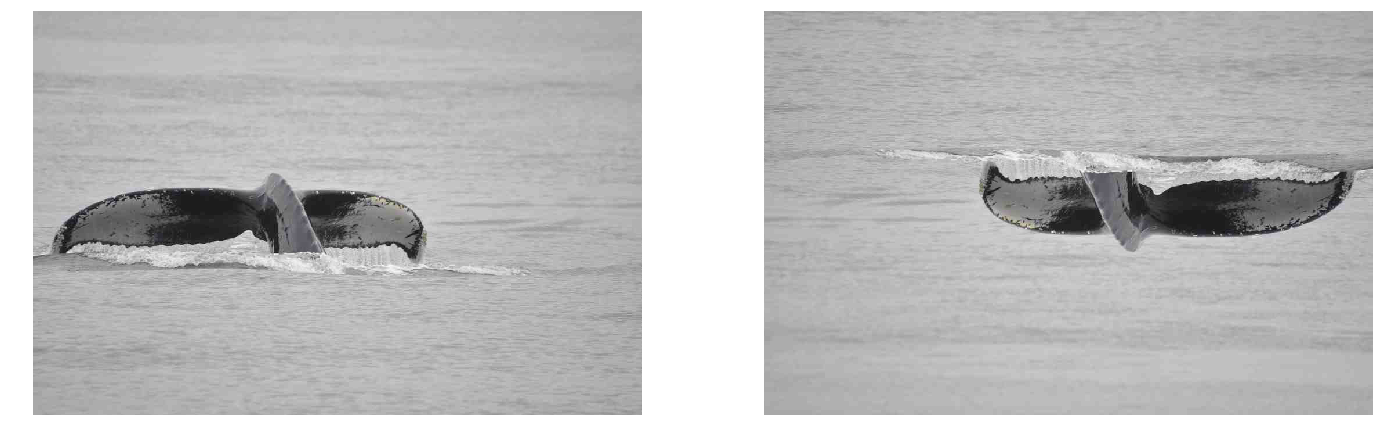

In [6]:
def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    if p in rotate: img = img.rotate(180)
    return img

def show_whale(imgs, per_row=2):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

p    = list(rotate)[0]
imgs = [pil_image.open(expand_path(p)), read_raw_image(p)]
show_whale(imgs)

In [7]:
# Read or generate p2h, a dictionary of image name to image id (picture to hash)

# Two phash values are considered duplicate if, for all associated image pairs:
# 1) They have the same mode and size;
# 2) After normalizing the pixel to zero mean and variance 1.0, the mean square error does not exceed 0.1
def match(h1,h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 = read_raw_image(p1)
            i2 = read_raw_image(p2)
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1/sqrt((a1**2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2/sqrt((a2**2).mean())
            a  = ((a1 - a2)**2).mean()
            if a > 0.1: return False
    return True

if isfile('./preprocessing_files/p2h.pickle'):
    with open('./preprocessing_files/p2h.pickle', 'rb') as f:
        p2h = pickle.load(f)
else:
    # Compute phash for each image in the training and test set.
    p2h = {}
    for p in tqdm_notebook(join):
        img    = pil_image.open(expand_path(p))
        h      = phash(img)
        p2h[p] = h

    # Find all images associated with a given phash value.
    h2ps = {}
    for p,h in p2h.items():
        if h not in h2ps: h2ps[h] = []
        if p not in h2ps[h]: h2ps[h].append(p)

    # Find all distinct phash values
    hs = list(h2ps.keys())
    
    # If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
    h2h = {}
    for i,h1 in enumerate(tqdm_notebook(hs)):
        for h2 in hs[:i]:
            if h1-h2 <= 6 and match(h1, h2):
                s1 = str(h1)
                s2 = str(h2)
                if s1 < s2: s1,s2 = s2,s1
                h2h[s1] = s2

    # Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
    for p,h in p2h.items():
        h = str(h)
        if h in h2h: h = h2h[h]
        p2h[p] = h

len(p2h), list(p2h.items())[:5]

(25460,
 [('1d9daef8.jpg', 'ed9996a6713c0e49'),
  ('14fbf502.jpg', 'e99295e572598e43'),
  ('22190656.jpg', 'fb4f403047613f4e'),
  ('45be5dfe.jpg', 'afc2d0a7e2b4e0b8'),
  ('c3a14539.jpg', '8671181ad627fab5')])

In [8]:
# For each image id, determine the list of pictures
h2ps = {}
for p,h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)
# Notice how 25460 images use only 20913 distinct image ids.
len(h2ps),list(h2ps.items())[:5]

(20913,
 [('dacad4352d28c8eb', ['184cf2e4.jpg']),
  ('9e85e036c8b84fba', ['7c189c00.jpg']),
  ('c0023fbfa582d2af', ['a380f5bf.jpg']),
  ('eada9485e572146d', ['7166c50f.jpg']),
  ('e61c99e166dc3b05', ['e4cd2332.jpg'])])

In [9]:
# For each images id, select the prefered image
def prefer(ps):
    if len(ps) == 1: return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0]*s[1] > best_s[0]*best_s[1]: # Select the image with highest resolution
            best_p = p
            best_s = s
    return best_p

h2p = {}
for h,ps in h2ps.items(): h2p[h] = prefer(ps)
len(h2p),list(h2p.items())[:5]

(20913,
 [('dacad4352d28c8eb', '184cf2e4.jpg'),
  ('9e85e036c8b84fba', '7c189c00.jpg'),
  ('c0023fbfa582d2af', 'a380f5bf.jpg'),
  ('8a97b7a2e468da4a', 'caabfbfa.jpg'),
  ('e61c99e166dc3b05', 'e4cd2332.jpg')])

In [10]:
def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    if p in rotate: img = img.rotate(180)
    return img

In [11]:
# Read the bounding box data from the bounding box kernel (see reference above)
with open('./preprocessing_files/bounding-box.pickle', 'rb') as f:
    p2bb = pickle.load(f)
list(p2bb.items())[:5]

[('1d9daef8.jpg', (144, 82, 838, 521)),
 ('14fbf502.jpg', (0, 69, 482, 247)),
 ('22190656.jpg', (67, 79, 971, 378)),
 ('45be5dfe.jpg', (-10, 3, 1029, 280)),
 ('c3a14539.jpg', (-18, -9, 1046, 275))]

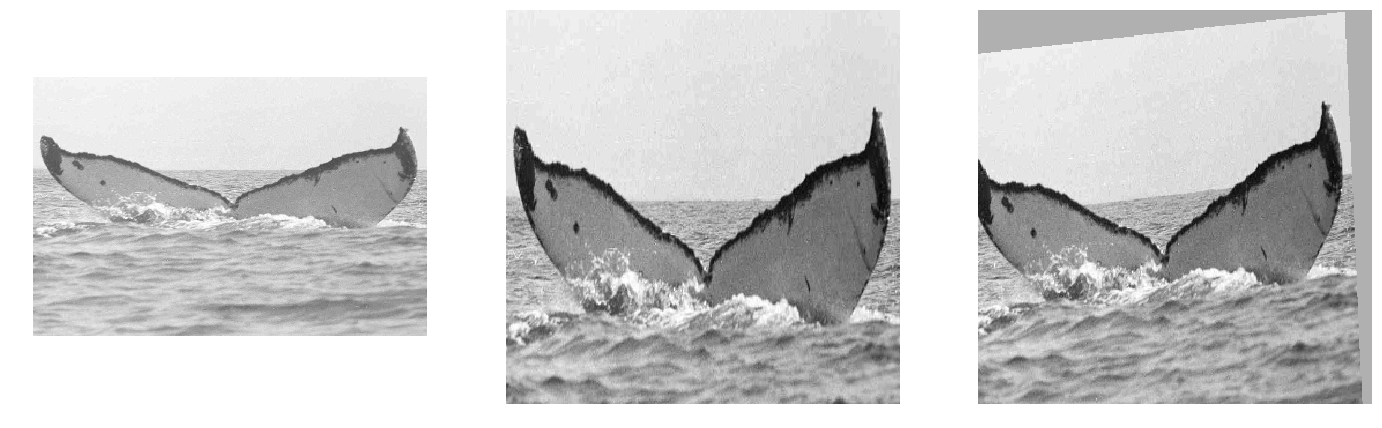

In [12]:
# Suppress annoying stderr output when importing keras.

img_shape    = (SIZE,SIZE,1) # The image shape used by the model
anisotropy   = 2.15 # The horizontal compression ratio
crop_margin  = 0.05 # The margin added around the bounding box to compensate for bounding box inaccuracy

def build_transform(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    Build a transformation matrix with the specified characteristics.
    """
    rotation        = np.deg2rad(rotation)
    shear           = np.deg2rad(shear)
    rotation_matrix = np.array([[np.cos(rotation), np.sin(rotation), 0], [-np.sin(rotation), np.cos(rotation), 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, height_shift], [0, 1, width_shift], [0, 0, 1]])
    shear_matrix    = np.array([[1, np.sin(shear), 0], [0, np.cos(shear), 0], [0, 0, 1]])
    zoom_matrix     = np.array([[1.0/height_zoom, 0, 0], [0, 1.0/width_zoom, 0], [0, 0, 1]])
    shift_matrix    = np.array([[1, 0, -height_shift], [0, 1, -width_shift], [0, 0, 1]])
    return np.dot(np.dot(rotation_matrix, shear_matrix), np.dot(zoom_matrix, shift_matrix))

def read_cropped_image(p, augment):
    """
    @param p : the name of the picture to read
    @param augment: True/False if data augmentation should be performed
    @return a numpy array with the transformed image
    """
    # If an image id was given, convert to filename
    if p in h2p: p = h2p[p]
    size_x,size_y = p2size[p]
    
    # Determine the region of the original image we want to capture based on the bounding box.
    x0,y0,x1,y1   = p2bb[p]
    if p in rotate: x0, y0, x1, y1 = size_x - x1, size_y - y1, size_x - x0, size_y - y0
    dx            = x1 - x0
    dy            = y1 - y0
    x0           -= dx*crop_margin
    x1           += dx*crop_margin + 1
    y0           -= dy*crop_margin
    y1           += dy*crop_margin + 1
    if (x0 < 0     ): x0 = 0
    if (x1 > size_x): x1 = size_x
    if (y0 < 0     ): y0 = 0
    if (y1 > size_y): y1 = size_y
    dx            = x1 - x0
    dy            = y1 - y0
    if dx > dy*anisotropy:
        dy  = 0.5*(dx/anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx  = 0.5*(dy*anisotropy - dx)
        x0 -= dx
        x1 += dx

    # Generate the transformation matrix
    trans = np.array([[1, 0, -0.5*img_shape[0]], [0, 1, -0.5*img_shape[1]], [0, 0, 1]])
    trans = np.dot(np.array([[(y1 - y0)/img_shape[0], 0, 0], [0, (x1 - x0)/img_shape[1], 0], [0, 0, 1]]), trans)
    if augment:
        trans = np.dot(build_transform(
            random.uniform(-5, 5),
            random.uniform(-5, 5),
            random.uniform(0.8, 1.0),
            random.uniform(0.8, 1.0),
            random.uniform(-0.05*(y1 - y0), 0.05*(y1 - y0)),
            random.uniform(-0.05*(x1 - x0), 0.05*(x1 - x0))
            ), trans)
    trans = np.dot(np.array([[1, 0, 0.5*(y1 + y0)], [0, 1, 0.5*(x1 + x0)], [0, 0, 1]]), trans)

    # Read the image, transform to black and white and comvert to numpy array
    img   = read_raw_image(p).convert('L')
    img   = img_to_array(img)
    
    # Apply affine transformation
    matrix = trans[:2,:2]
    offset = trans[:2,2]
    img    = img.reshape(img.shape[:-1])
    img    = affine_transform(img, matrix, offset, output_shape=img_shape[:-1], order=1, mode='constant', cval=np.average(img))
    img    = img.reshape(img_shape)

    # Normalize to zero mean and unit variance
    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) + K.epsilon()
    return img

def read_for_training(p):
    """
    Read and preprocess an image with data augmentation (random transform).
    """
    return read_cropped_image(p, True)

def read_for_validation(p):
    """
    Read and preprocess an image without data augmentation (use for testing).
    """
    return read_cropped_image(p, False)

p = list(tagged.keys())[321]
imgs = [
    read_raw_image(p),
    array_to_img(read_for_validation(p)),
    array_to_img(read_for_training(p))
]
show_whale(imgs, per_row=3)

In [13]:
with open('./preprocessing_files/exclude.txt', 'rt') as f: exclude = f.read().split('\n')[:-1]   

In [14]:
# Find all the whales associated with an image id. It can be ambiguous as duplicate images may have different whale ids.
h2ws = {}
new_whale = 'new_whale'
for p,w in tagged.items():
    if w != new_whale: # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h,ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)
len(h2ws)

8412

In [15]:
h2ws_unamb = {}
for h,ws in h2ws.items():
    if len(ws) == 1: # Use only unambiguous pictures
        if h2p[h] not in exclude:
            h2ws_unamb[h] = ws[0]            

In [16]:
preSplitArray = []
for key, value in h2ws_unamb.items():
    entry = []
    entry.append(key)
    entry.append(value)
    preSplitArray.append(entry)
np.random.shuffle(preSplitArray)

trainArray = preSplitArray[:7000]
testArray = preSplitArray[7000:]

trainArray = np.array(trainArray)
testArray = np.array(testArray)
bothArray = np.array(preSplitArray)
train_dict = dict(zip(trainArray[:, 0], trainArray[:, 1]))
test_dict = dict(zip(testArray[:, 0], testArray[:, 1] ))
both_dict = dict(zip(bothArray[:, 0], bothArray[:, 1] ))
len(both_dict)

8402

In [18]:
def createSet(train_dict):
    # For each whale, find the unambiguous images ids.
    w2hs = {}
    
    for h,ws in train_dict.items():
        w = ws
        if w not in w2hs: w2hs[w] = []
        if h not in w2hs[w]: w2hs[w].append(h)
        
 
    for w,hs in w2hs.items():
        if len(hs) > 1:
            w2hs[w] = sorted(hs)

    # Find the list of training images, keep only whales with at least two images.
    train = [] # A list of training image ids
    for hs in w2hs.values():
        if len(hs) > 1:
            train += hs
    random.shuffle(train)
    train_set = set(train)

    w2ts = {} # Associate the image ids from train to each whale id.
    for w,hs in w2hs.items():
        for h in hs:
            if h in train_set:
                if w not in w2ts: w2ts[w] = []
                if h not in w2ts[w]: w2ts[w].append(h)
    for w,ts in w2ts.items(): w2ts[w] = np.array(ts)
    
    t2i = {} # The position in train of each training image id
    for i,t in enumerate(train): t2i[t] = i

    len(train),len(w2ts)
    #w2ts has whale ID's mapped to hashes of images
    
    train_data = []
    for key, value in w2ts.items():
        train_data.append(value)
    
    return train_data

In [19]:
len(train_dict),len(test_dict)

(7000, 1402)

In [20]:
both_data = createSet(both_dict)

In [21]:
train_data = createSet(train_dict)
test_data = createSet(test_dict)

len(train_data), len(test_data)

(1564, 177)

In [44]:
num_classes = len(both_data)
num_classes

1912

In [28]:
def labels_to_int(array):
        x_data = []
        labels = []
      
        for i in range(len(array)):
            for j in (range (len(array[i]))):
                h = array[i][j]
                x_data += [h]
                labels += [i]
            
                
        int_labels_dict = dict(zip(x_data, labels))
        return int_labels_dict
h2int = labels_to_int(both_data)

In [29]:
def create_data(multWhaleArray, h2p, h2w):
        x_data = []
        labels = []
        for i in range(len(multWhaleArray)):
            for j in (range (len(multWhaleArray[i]))):
                h = multWhaleArray[i][j]
                x_data += [h2p[h]]
                labels += [h2int[h]]
                #labels += [i]
        return x_data, labels

In [30]:
x_train_pic, y_train = create_data(train_data, h2p, train_dict)

In [31]:
x_test_pic, y_test = create_data(test_data, h2p, test_dict)

In [32]:
def ImportImage(filename):
    img = Image.open(filename).convert("RGB").resize((SIZE,SIZE))
    x = np.array(img)
    return x

def ImagesToArray(img_name, validation):
    images = []
    for i in tqdm_notebook(range(len(img_name))):
        if validation: 
            images.append((read_for_validation(img_name[i])))
        else:
            images.append((read_for_training(img_name[i])))
    return np.array(images)

x_train = ImagesToArray(x_train_pic, False)
x_test = ImagesToArray(x_test_pic, True)

/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


In [33]:
DIR2 = './saved_arrays/'

np.save(DIR2+'x_train.npy', x_train)
np.save(DIR2+'y_train.npy', y_train)
np.save(DIR2+'x_test.npy', x_test)
np.save(DIR2+'y_test.npy', y_test)

In [2]:
DIR2 = './saved_arrays/'

x_train = np.load(DIR2+'x_train.npy')
y_train = np.load(DIR2+'y_train.npy')
x_test = np.load(DIR2+'x_test.npy')
y_test = np.load(DIR2+'y_test.npy')

num_classes = max(np.max(y_test), np.max(y_train))+1

In [8]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorpack import *
from tensorpack.tfutils.summary import add_moving_summary
from tensorpack.utils.gpu import change_gpu

def center_loss(embedding, label, num_classes, alpha=0.1, scope="center_loss"):
    r"""Center-Loss as described in the paper
    `A Discriminative Feature Learning Approach for Deep Face Recognition`
    <http://ydwen.github.io/papers/WenECCV16.pdf> by Wen et al.
    Args:
        embedding (tf.Tensor): features produced by the network
        label (tf.Tensor): ground-truth label for each feature
        num_classes (int): number of different classes
        alpha (float): learning rate for updating the centers
    Returns:
        tf.Tensor: center loss
    """
    nrof_features = embedding.get_shape()[1]
    
    centers = tf.get_variable('centers', [num_classes, nrof_features], dtype=tf.float32,
                              initializer=tf.constant_initializer(0), trainable=False)
    tf.variable_scope('centers', reuse=tf.AUTO_REUSE)
    label = tf.reshape(label, [-1])
    centers_batch = tf.gather(centers, label)
    diff = (1 - alpha) * (centers_batch - embedding)
    centers = tf.scatter_sub(centers, label, diff)
    loss = tf.reduce_mean(tf.square(embedding - centers_batch), name=scope)
    return loss

In [9]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
from keras import initializers

num_features = 512

class ComputeCenter(Layer):
    #self.y_true = []
    W = []
    y_true = []
    k = -1
    def __init__(self, output_dim, a_y_true, moving_mean_initializer='zeros', **kwargs):
        self.output_dim = output_dim
        self.y_true = a_y_true
        self.k = -1
        super(ComputeCenter, self).__init__(**kwargs)
        self.moving_mean_initializer = initializers.get(moving_mean_initializer)
        
    def build(self, y_pred):
        super(ComputeCenter, self).build(y_pred)

    def call(self, x):
        print(x)
        self.k = self.k+1
        loss = center_loss(x, self.y_true[self.k], num_classes)
        print(loss)
        #self.add_loss(loss, x)
        return loss

    def compute_output_shape(self, y_pred):
        #print(self.output_dim)
        return (y_pred[0], self.output_dim)

In [10]:
def top_k_categorical(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=20)

In [11]:
def corr_loss(y_true, y_pred):
    #print y_true.type,y_pred.type
    #return K.zeros_like(y_pred)
    return y_pred

In [12]:
from keras import regularizers
from keras.optimizers import Adam
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape
from keras.models import Model

def subblock(x, filter, **kwargs):
    #x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y) # Reduce the number of features to 'filter'
    #y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y) # Extend the feature field
    #y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y) # no activation # Restore the number of original features
    y = Add()([x,y]) # Add the bypass connection
    y = Activation('relu')(y)
    return y

def branch_network(lr, l2, input_shape):
    regul  = regularizers.l2(l2)
    optim  = Adam(lr=lr)
    kwargs = {'padding':'same', 'kernel_regularizer':regul}

    inp = Input(shape=input_shape) # 384x384x1
    x   = Conv2D(64, (9,9), strides=2, activation='relu', **kwargs)(inp)

    x   = MaxPooling2D((2, 2), strides=(2, 2))(x) # 96x96x64
    #x = Dropout(0.2)(x)
    for _ in range(2):
        #x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 48x48x64
    #x = Dropout(0.25)(x)
  #  x = BatchNormalization()(x)
    x = Conv2D(128, (1,1), activation='relu', **kwargs)(x) # 48x48x128
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 24x24x128
    #x = Dropout(0.25)(x)
  #  x = BatchNormalization()(x)
    x = Conv2D(256, (1,1), activation='relu', **kwargs)(x) # 24x24x256
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 12x12x256
    #x = Dropout(0.25)(x)
  #  x = BatchNormalization()(x)
    x = Conv2D(384, (1,1), activation='relu', **kwargs)(x) # 12x12x384
    for _ in range(4): x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 6x6x384
    #x = Dropout(0.25)(x)
    #x = BatchNormalization()(x)
    x = Conv2D(512, (1,1), activation='relu', **kwargs)(x) # 6x6x512
    for _ in range(4): x = subblock(x, 128, **kwargs)
    
    x             = GlobalMaxPooling2D()(x) # 512
    x = Dense(num_classes)(x)
    
    y = ComputeCenter(1, y_train)(x)
    x = Activation('softmax')(x)
    branch_model  = Model(inp, [x, y])
    
    branch_model.summary()
    return branch_model

In [13]:
# network definition
input_shape = (SIZE, SIZE, 1)
tf.variable_scope('centers', reuse=tf.AUTO_REUSE)
model = branch_network(64e-5, 0, input_shape)

#model = Input(shape=input_shape)

Tensor("dense_1/BiasAdd:0", shape=(?, 1912), dtype=float32)
Tensor("compute_center_1/center_loss:0", shape=(), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 341, 341, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 171, 171, 64) 5248        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 85, 85, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 85, 85, 64)   36928       max_pooling2d_1[0

In [14]:
num_classes

1912

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 341, 341, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 171, 171, 64) 5248        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 85, 85, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 85, 85, 64)   36928       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_3 (

In [16]:
model.load_weights('./whale_tail_weights/weights_euclidean.hdf5', by_name = True)

In [ ]:
sgd = SGD(lr = 0.01, decay=1e-6, momentum=0.9, nesterov=True)
#rms = RMSprop(lr=0.1)
#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

from keras.utils.np_utils import to_categorical
cat_train = to_categorical(y_train, num_classes=num_classes)
cat_test = to_categorical(y_test, num_classes=num_classes)
model.compile(loss=['categorical_crossentropy', corr_loss], optimizer=sgd, metrics={'activation_17': top_k_categorical})
history = model.fit(x_train, [cat_train, np.zeros((x_train.shape[0], 50))],
          batch_size=32, #validation_split = 0.289,
          validation_data = (x_test, [cat_test, np.zeros((x_test.shape[0], 50))]),
          epochs=10, initial_epoch = 0, shuffle = True)

Train on 4746 samples, validate on 417 samples
Epoch 1/10
4746/4746 [==============================] - 58s 12ms/step - loss: 7.5505 - activation_17_loss: 7.5470 - compute_center_1_loss: 0.0035 - activation_17_top_k_categorical: 0.0354 - val_loss: 7.5231 - val_activation_17_loss: 7.5174 - val_compute_center_1_loss: 0.0057 - val_activation_17_top_k_categorical: 0.0935
Epoch 2/10
4746/4746 [==============================] - 47s 10ms/step - loss: 7.5100 - activation_17_loss: 7.4862 - compute_center_1_loss: 0.0238 - activation_17_top_k_categorical: 0.0611 - val_loss: 7.4485 - val_activation_17_loss: 7.4173 - val_compute_center_1_loss: 0.0312 - val_activation_17_top_k_categorical: 0.1103
Epoch 3/10
4608/4746 [============================>.] - ETA: 1s - loss: 7.4725 - activation_17_loss: 7.4256 - compute_center_1_loss: 0.0469 - activation_17_top_k_categorical: 0.0679

In [31]:
# list all data in history
print(history.history.keys())

dict_keys(['compute_center_1_loss', 'val_compute_center_1_loss', 'val_activation_17_loss', 'loss', 'val_loss', 'activation_17_loss', 'activation_17_top_k_categorical', 'val_activation_17_top_k_categorical'])


dict_keys(['compute_center_1_loss', 'val_compute_center_1_loss', 'val_activation_17_loss', 'loss', 'val_loss', 'activation_17_loss', 'activation_17_top_k_categorical', 'val_activation_17_top_k_categorical'])


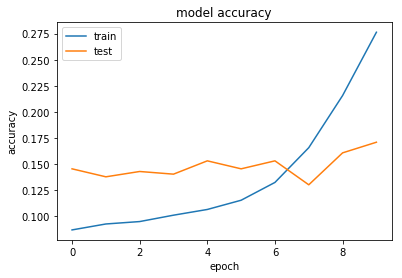

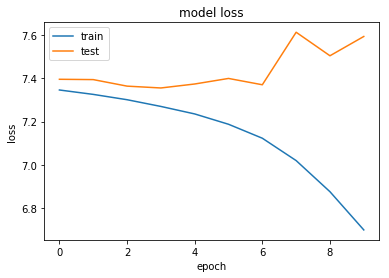

In [32]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['activation_17_top_k_categorical'])
plt.plot(history.history['val_activation_17_top_k_categorical'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()